Author: Diane Menuz  
Date: June 10, 2025  
Purpose: Compare ET data downloaded from OpenET to ET values from eddy station.  
Analysis includes time series plot, OLS, and Bland-Altman plots

# Parameters and Libraries

In [47]:
stationid = 'US-CdM'
start_date = '2024-01-01 0:00' # first data for data analysis
end_date = '2024-12-31 23:00' # last date of data analysis

openet_file = r'M:\My Drive\projects\eddy_covariance\analysis\cedarmesa_2024_daily_from_openet_25acre_studyarea.csv'

micromet_path= "C:/Users/dmenuz/Documents/scripts/MicroMet/src/micromet"
loggerloader_path= "C:/Users/dmenuz/Documents/scripts/loggerloader"
eddy_plots = 'C:/Users/dmenuz/Documents/scripts/eddy'



In [48]:
import pandas as pd
import numpy as np

import importlib.util
from sqlalchemy import create_engine, inspect
from urllib.parse import quote  
import requests
import json

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import linregress
import statsmodels.api as sm

import plotly.io as pio
pio.renderers.default = 'notebook' 



In [49]:
# import functions
import sys
sys.path.append(micromet_path)
import graphs as mm_graphs

sys.path.append(loggerloader_path)
import loggerloader as ll

sys.path.append(eddy_plots)
import eddy_plots as ed_plot

# Import Data

In [50]:
openet = pd.read_csv(openet_file)
openet['DateTime'] = pd.to_datetime(openet['DateTime'])
openet.set_index('DateTime', inplace=True)

In [ ]:
spec = importlib.util.spec_from_file_location("dbconnect", "C:/Users/dmenuz/Documents/scripts/supporting_files/dbconnect_cloud.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)

engine = dbconnect.postconn_ugs_read()

In [52]:
query = "SELECT * FROM groundwater.amfluxeddy WHERE stationid = %(sid)s AND datetime_start >= %(sdate)s and datetime_start <=%(edate)s"
params = {'sid': stationid, 'sdate': start_date, 'edate': end_date}
try:
    eddy = pd.read_sql(query, engine, params=params)
except Exception as e:
    print(f"Error with parameterized query (named): {e}")
eddy.set_index('datetime_start', inplace=True)

# Clean Up and Merge Data

In [53]:
# convert open et from inches to mm depending on how you download data
# conversion_factor = 25.4
# openet_mm = openet.apply(lambda x: x * conversion_factor if pd.api.types.is_numeric_dtype(x) else x)

In [54]:
# convert eddy station hourly rates to 30 min accumulation
eddy_clean = eddy[eddy.et>-9999]
eddy_clean['eddy_et'] = eddy_clean['et']*0.5

In [55]:
# calculate number of records per day and drop days without 48 records
daily_agg_data = eddy_clean.resample('D').agg({
    'eddy_et':'sum',
    'et_ssitc_test':'mean',
    'stationid':'count',
})
daily_clean = daily_agg_data[daily_agg_data.stationid==48]

In [62]:
# merge openet with eddyet together
# UPDATE MERGE DEPENDING ON WHAT UNITS OPENET DATA WERE IN!

et_merge = pd.merge(daily_clean[['eddy_et', 'et_ssitc_test']], openet, how='inner', left_index=True, right_index=True)
print(f'{len(et_merge)} records for analysis')

319 records for analysis


In [63]:
# clean up openet column names
new_columns = {col: col.replace(' ET', '') for col in et_merge.columns}
et_merge = et_merge.rename(columns=new_columns)
new_columns = {col: col.replace('-', '_') for col in et_merge.columns}
et_merge = et_merge.rename(columns=new_columns)

In [64]:
et_merge.describe()

eddy_et  et_ssitc_test    Ensemble    eeMetric      SSEBop  \
count  319.000000     319.000000  319.000000  319.000000  319.000000   
mean     0.721224       1.047283    0.671727    0.180592    0.872856   
std      0.565566       0.312462    0.435813    0.202526    0.532811   
min     -0.141171       0.229167    0.107000    0.000000    0.108000   
25%      0.276192       0.843750    0.382000    0.020500    0.356000   
50%      0.645486       1.062500    0.594000    0.081000    0.847000   
75%      0.992045       1.291667    0.837500    0.304500    1.328000   
max      2.829909       1.729167    2.515000    0.858000    2.165000   

           PT_JPL    DisALEXI    geeSEBAL  Unnamed: 7  
count  319.000000  319.000000  319.000000         0.0  
mean     1.012517    0.748257    0.397922         NaN  
std      0.460024    0.505043    0.588605         NaN  
min      0.213000    0.118000    0.000000         NaN  
25%      0.570000    0.416000    0.007500         NaN  
50%      1.027000    0.603000    0.096000         NaN  
75%      1.376500    0.882500    0.565000         NaN  
max      2.226000    3.159000    3.062000         NaN

# Comparison

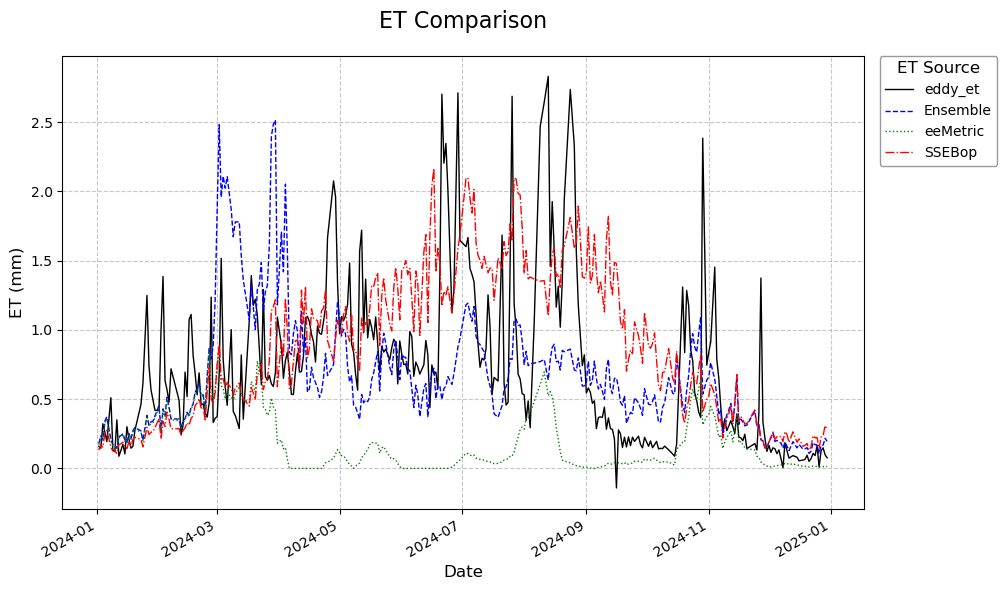

In [78]:
df = et_merge.copy()
cols=['eddy_et', 'Ensemble', 'eeMetric', 'SSEBop']
title = 'ET Comparison'
save_fig_name = f'et_timeseries_{stationid}_2024.png'

# time series plot


%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6)) 

ax.plot(df.index, df[cols[0]] , label=f'{cols[0]}', 
        color='black', linestyle='-', linewidth=1)
ax.plot(df.index, df[cols[1]] , label=f'{cols[1]}', 
        color='blue', linestyle='--', linewidth=1)
ax.plot(df.index, df[cols[2]] , label=f'{cols[2]}', 
        color='green', linestyle=':', linewidth=1)
ax.plot(df.index, df[cols[3]] , label=f'{cols[3]}', 
        color='red', linestyle='-.', linewidth=1)


ax.set_title(title, fontsize=16, pad=20) 
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('ET (mm)', fontsize=12)

# Customize the legend
ax.legend(
    loc='upper left',       
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.,     
    title='ET Source',    
    fontsize=10,         
    title_fontsize=12,   
    frameon=True,        
    edgecolor='gray',    
    facecolor='white',   
    shadow=False         
)


fig.autofmt_xdate() 

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig(save_fig_name)

plt.show()
plt.close() 

In [70]:
# regression parametres- though a poor way to look at the data!
vars = et_merge.columns[2:] 

regression_results = []

for var in vars: 
    temp_df = et_merge[['eddy_et', var]]
    x = temp_df['eddy_et']
    y = temp_df[var]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    regression_results.append({
        'Model': var,
        'Slope': slope,
        'Intercept': intercept,
        'R-squared': r_value**2, 
        'P-value': p_value,
        'Std Error': std_err,
        'N': len(x) 
    })

results_df = pd.DataFrame(regression_results)
print(round(results_df, 2))

        Model  Slope  Intercept  R-squared  P-value  Std Error    N
0    Ensemble   0.23       0.51       0.09     0.00       0.04  319
1    eeMetric   0.03       0.16       0.01     0.12       0.02  319
2      SSEBop   0.43       0.56       0.21     0.00       0.05  319
3      PT_JPL   0.44       0.69       0.29     0.00       0.04  319
4    DisALEXI   0.20       0.61       0.05     0.00       0.05  319
5    geeSEBAL   0.05       0.36       0.00     0.40       0.06  319
6  Unnamed: 7    NaN        NaN        NaN      NaN        NaN  319


<Figure size 1500x1000 with 0 Axes>

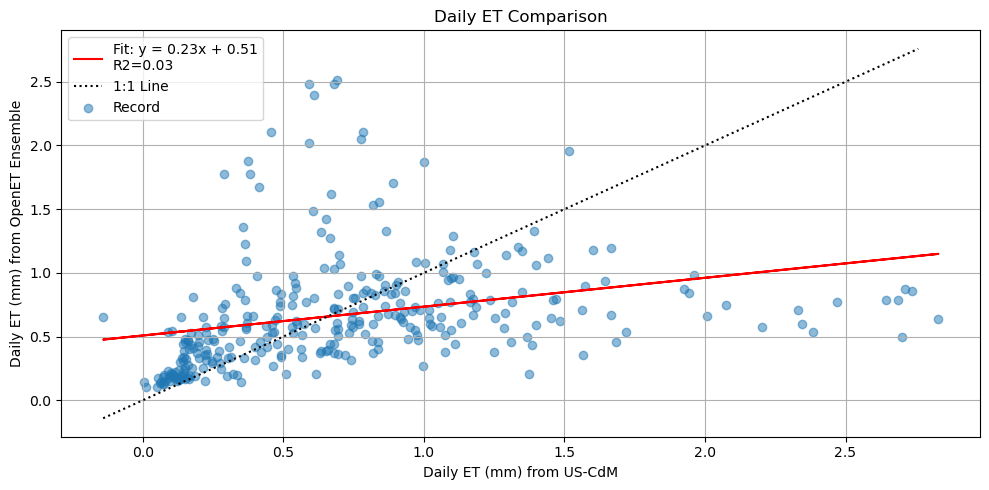

<Figure size 1500x1000 with 0 Axes>

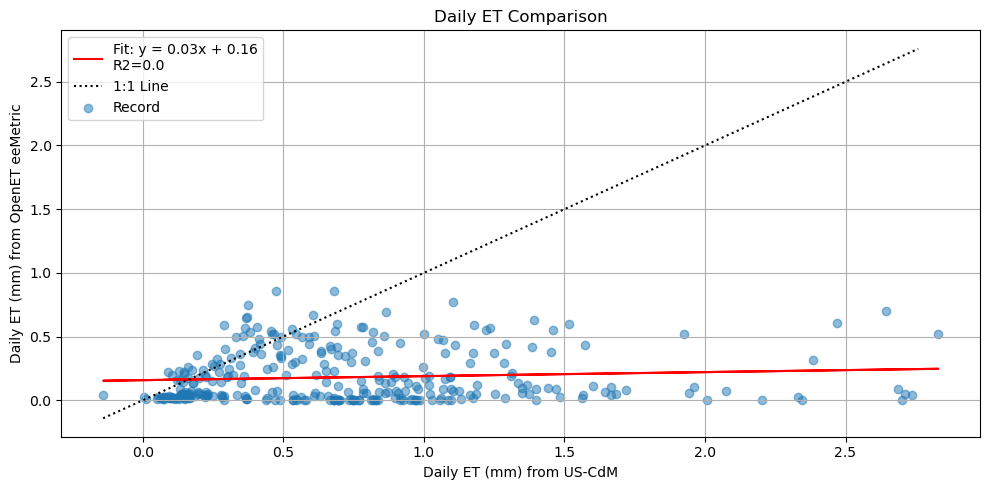

<Figure size 1500x1000 with 0 Axes>

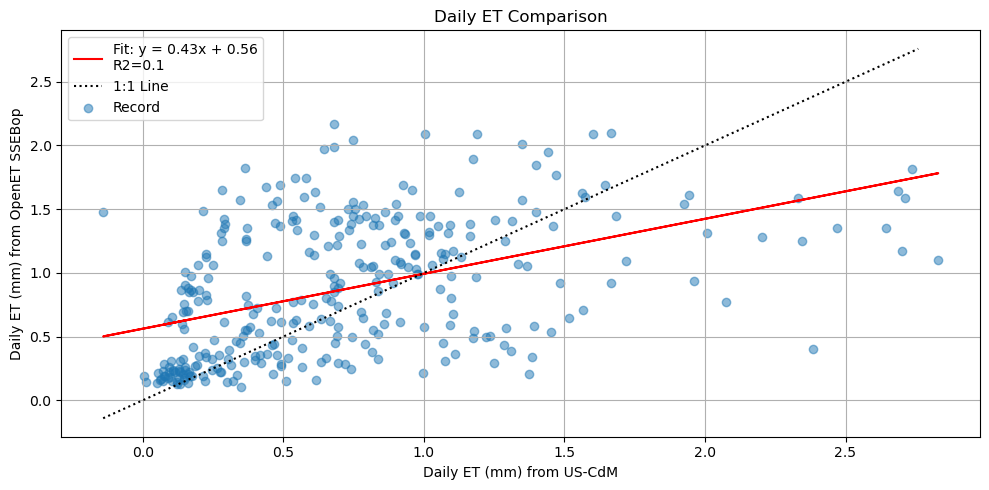

<Figure size 1500x1000 with 0 Axes>

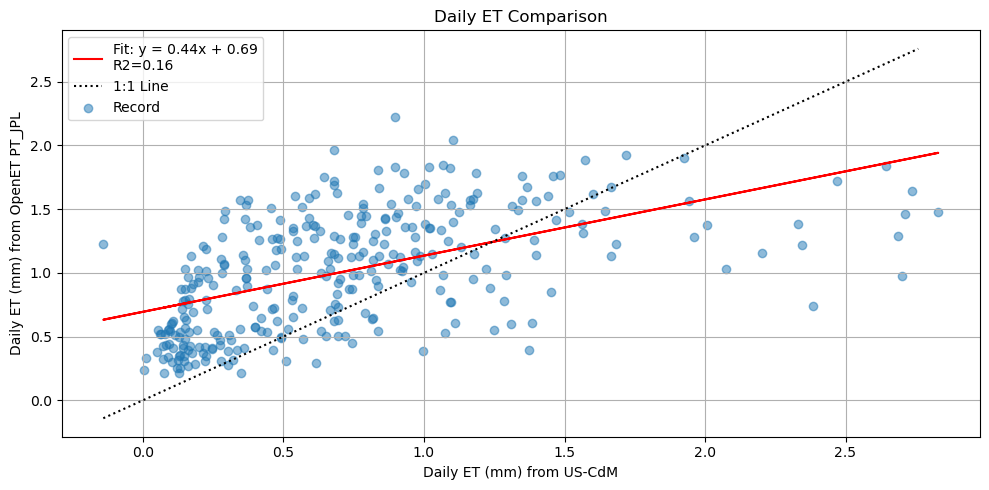

<Figure size 1500x1000 with 0 Axes>

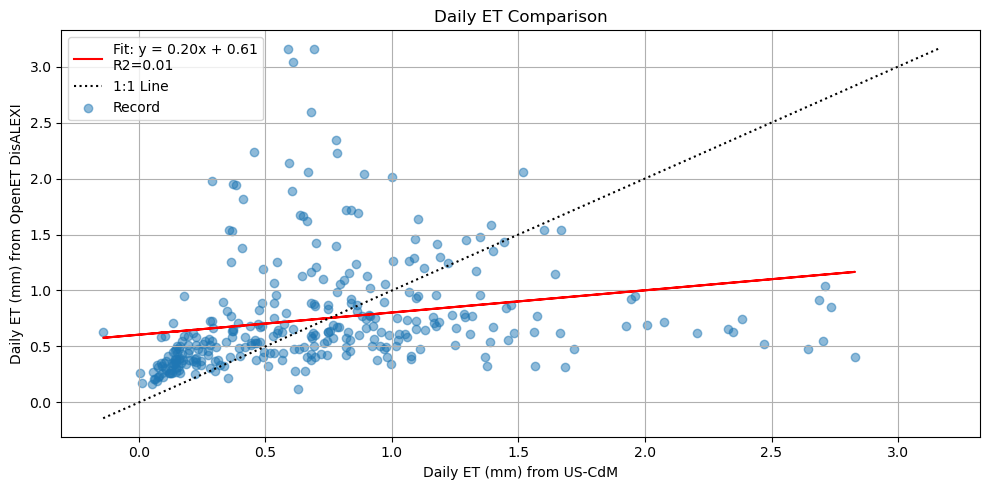

<Figure size 1500x1000 with 0 Axes>

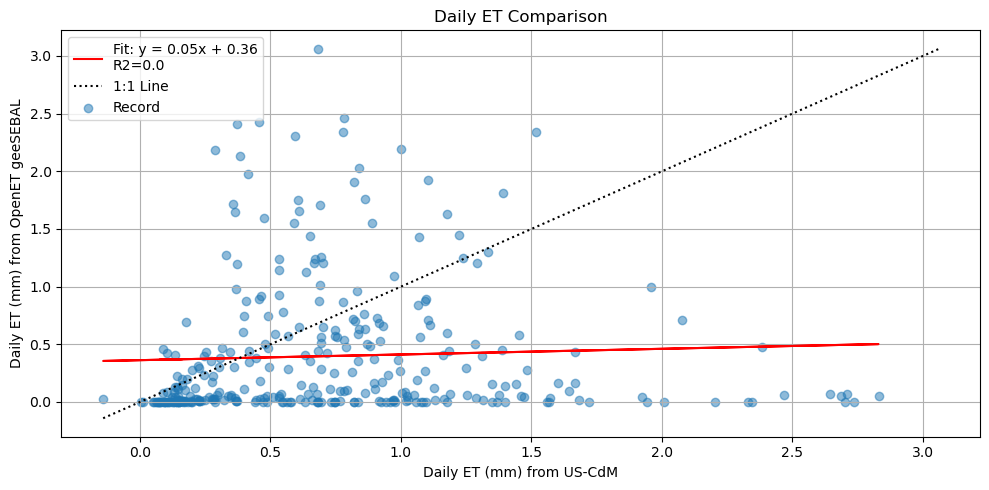

<Figure size 1500x1000 with 0 Axes>

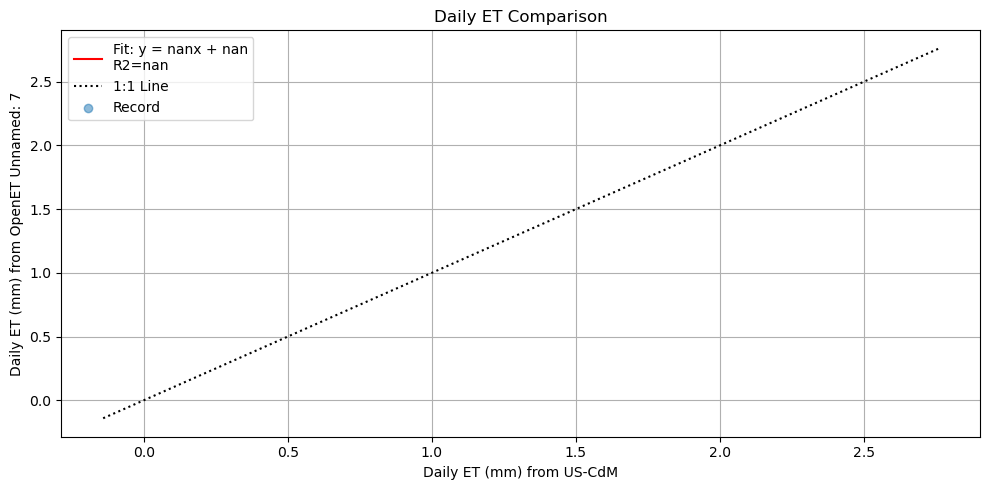

In [71]:
## ols plots 
%matplotlib inline

vars = et_merge.columns[2:]
for var in vars:
    plt.figure()  
    ed_plot.ols_plot(et_merge['eddy_et'], et_merge[var], 
        xlabel=f'Daily ET (mm) from {stationid}', 
        ylabel=f'Daily ET (mm) from OpenET {var}', 
        title= f'Daily ET Comparison')
    plt.tight_layout()  
    plt.savefig(f'ols_{stationid}_{var}.png')
    plt.show()
    plt.close()

In [72]:
## student t plots
for var in vars:
    student_resid_plot(et_merge, 'eddy_et', var, f'Studentized residuals for regression of Eddy ET and OpenET {var} model')

NameError: name 'student_resid_plot' is not defined

Bland-Altman plot for Ensemble


<Figure size 1500x1000 with 0 Axes>

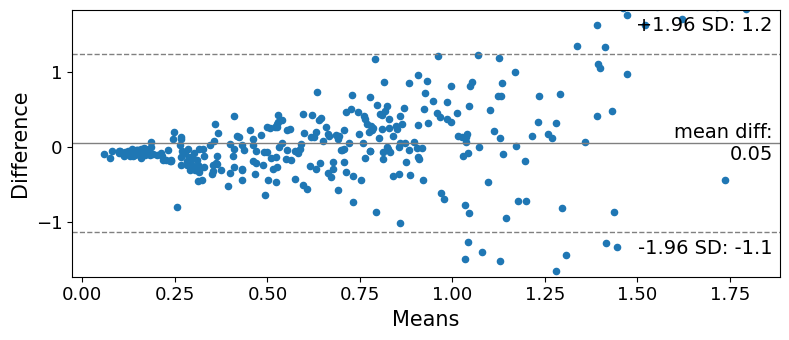

Bland-Altman plot for eeMetric


<Figure size 1500x1000 with 0 Axes>

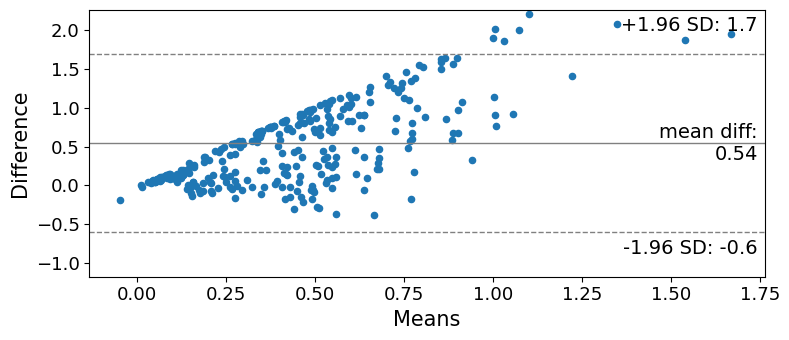

Bland-Altman plot for SSEBop


<Figure size 1500x1000 with 0 Axes>

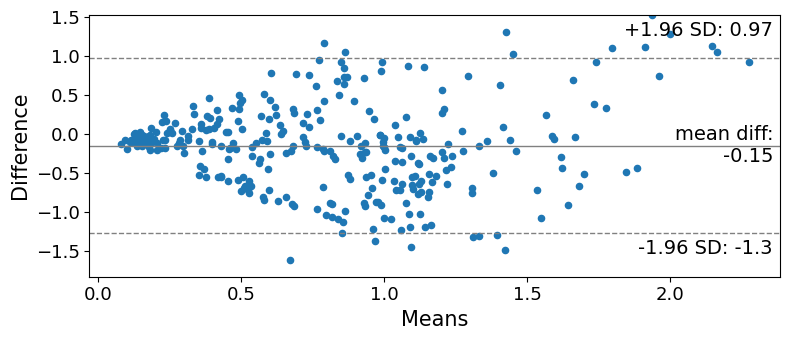

Bland-Altman plot for PT_JPL


<Figure size 1500x1000 with 0 Axes>

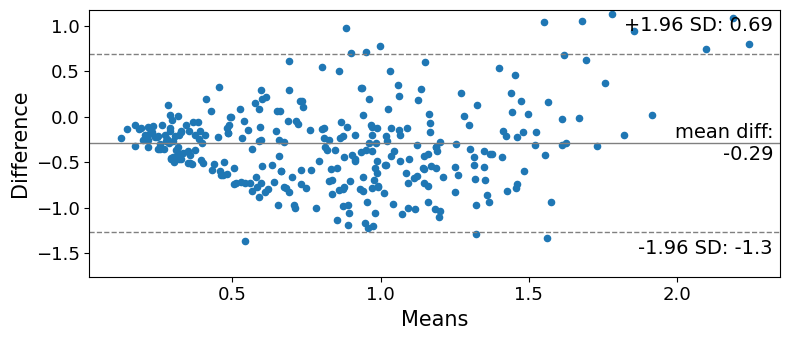

Bland-Altman plot for DisALEXI


<Figure size 1500x1000 with 0 Axes>

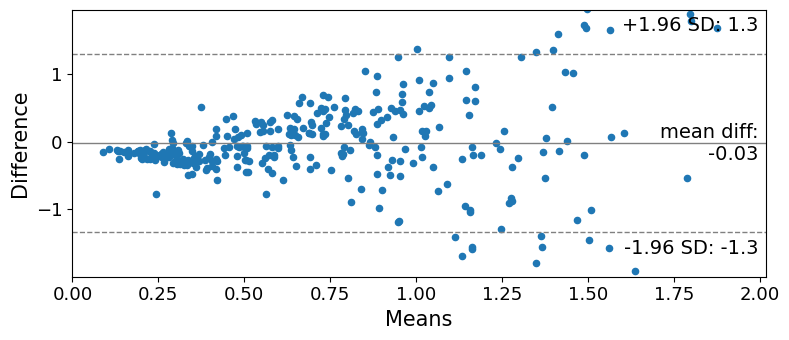

Bland-Altman plot for geeSEBAL


<Figure size 1500x1000 with 0 Axes>

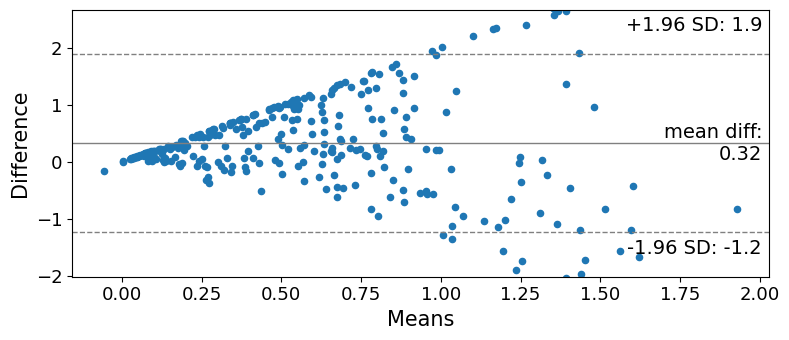

Bland-Altman plot for Unnamed: 7


ValueError: Axis limits cannot be NaN or Inf

<Figure size 1500x1000 with 0 Axes>

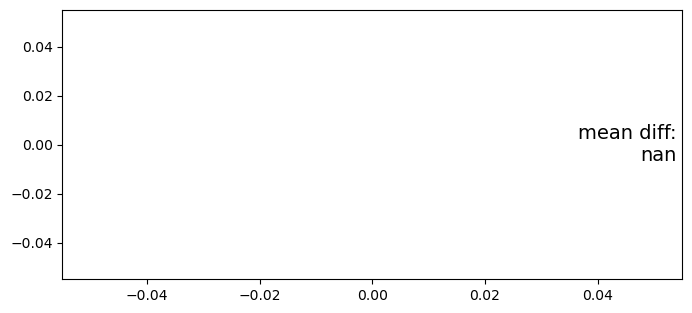

In [75]:
## bland-altman
for var in vars:
    print(f'Bland-Altman plot for {var}')
    plt.figure()  
    f, ax = plt.subplots(1, figsize = (8,3.5))
    sm.graphics.mean_diff_plot(et_merge['eddy_et'], et_merge[var], ax = ax)
    plt.tight_layout()  
    plt.savefig(f'ba_{stationid}_{var}.png')
    plt.show()
    plt.close() 

In [76]:
# scatter plots color-coded by data quality
et_merge['month'] = et_merge.index.month
et_merge_plot = et_merge.reset_index() # This turns the index into a column named 'index' by default
et_merge_plot = et_merge_plot.rename(columns={'index': 'date'}) # Rename 'index' to 'date' for clarity

for var in vars:

    fig = px.scatter(
        data_frame=et_merge_plot,  # Use the DataFrame that includes 'date' as a column
        x='eddy_et',                # Pass column name as a string
        y=f'{var}',           # Pass column name as a string
        color='month',     # Pass column name as a string for color-coding
        hover_data=['date', 'et_ssitc_test'], # List of column names (strings) to show on hover
        title=f'eddy_et vs. {var}' # Add a title for clarity
    )

    fig.update_layout(
        width=800,
        height=350 
        )

    min_val = min(et_merge_plot['eddy_et'].min(), et_merge_plot[f'{var}'].min())
    max_val = max(et_merge_plot['eddy_et'].max(), et_merge_plot[f'{var}'].max())
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    line_coords = np.linspace(min_val, max_val, 100)

    fig.add_trace(
        go.Scatter(
            x=line_coords,
            y=line_coords,
            mode='lines',
            showlegend=False,
            line=dict(color='black', dash='dot', width=1.5), # Style the line
            hoverinfo='skip' # Don't show hover info for the line itself
        )
    )

    fig.show()

# Monthly Data

In [77]:
monthly = et_merge.resample('ME').sum()

In [74]:
# monthlyscatter plots color-coded by data quality
monthly_plot = monthly.reset_index() # This turns the index into a column named 'index' by default
monthly_plot = monthly_plot.rename(columns={'index': 'date'})
monthly_plot['month_label'] = monthly_plot['date'].dt.month 



for var in vars:
    fig = px.scatter(
        data_frame=monthly_plot,
        x='eddy_et',       
        y=f'{var}',       
        title=f'Monthly eddy_et vs. {var}',
        text='month_label'
    )
    fig.update_traces(textposition='top right')
    fig.update_layout(
        width=800,
        height=400 
        )

    min_val = min(monthly_plot['eddy_et'].min(), monthly_plot[f'{var}'].min())
    max_val = max(monthly_plot['eddy_et'].max(), monthly_plot[f'{var}'].max())
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    line_coords = np.linspace(min_val, max_val, 100)

    fig.add_trace(
        go.Scatter(
            x=line_coords,
            y=line_coords,
            mode='lines',
            showlegend=False,
            line=dict(color='black', dash='dot', width=1.5), 
            hoverinfo='skip' 
        )
    )

    fig.show()